<a href="https://colab.research.google.com/github/YoishD/Data-Science-B7/blob/main/Copy_of_YeshDakpU8proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import arviz as az
!pip install ucimlrepo
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
from sklearn import tree
!pip install pymc-bart
!pip install preliz
import pymc_bart as pmb
import preliz as pz
from ucimlrepo import fetch_ucirepo

I found some data on housing prices in Sindian Dist. New Taipei City, Taiwan,and I thought that it would well with our BART model since I have no clue how any of these variables actually effect our overall house price per unit of area. Aside from the MRT(Metro Rail System)  distance variable as typically the closer you are to a metro, the closier you are to a more urban environment, which tend to be most expensive per area than rural housing. And since this is the only variable I am sure on, effects housing prices, I am gonna use this as my x axis later on while modeling

In [ ]:
rev= pd.read_csv('https://raw.githubusercontent.com/YoishD/Data-Science-B7/refs/heads/main/Real%20estate%20valuation%20data%20set.csv')
rev

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1
...,...,...,...,...,...,...,...,...
409,410,2013.000,13.7,4082.01500,0,24.94155,121.50381,15.4
410,411,2012.667,5.6,90.45606,9,24.97433,121.54310,50.0
411,412,2013.250,18.8,390.96960,7,24.97923,121.53986,40.6
412,413,2013.000,8.1,104.81010,5,24.96674,121.54067,52.5


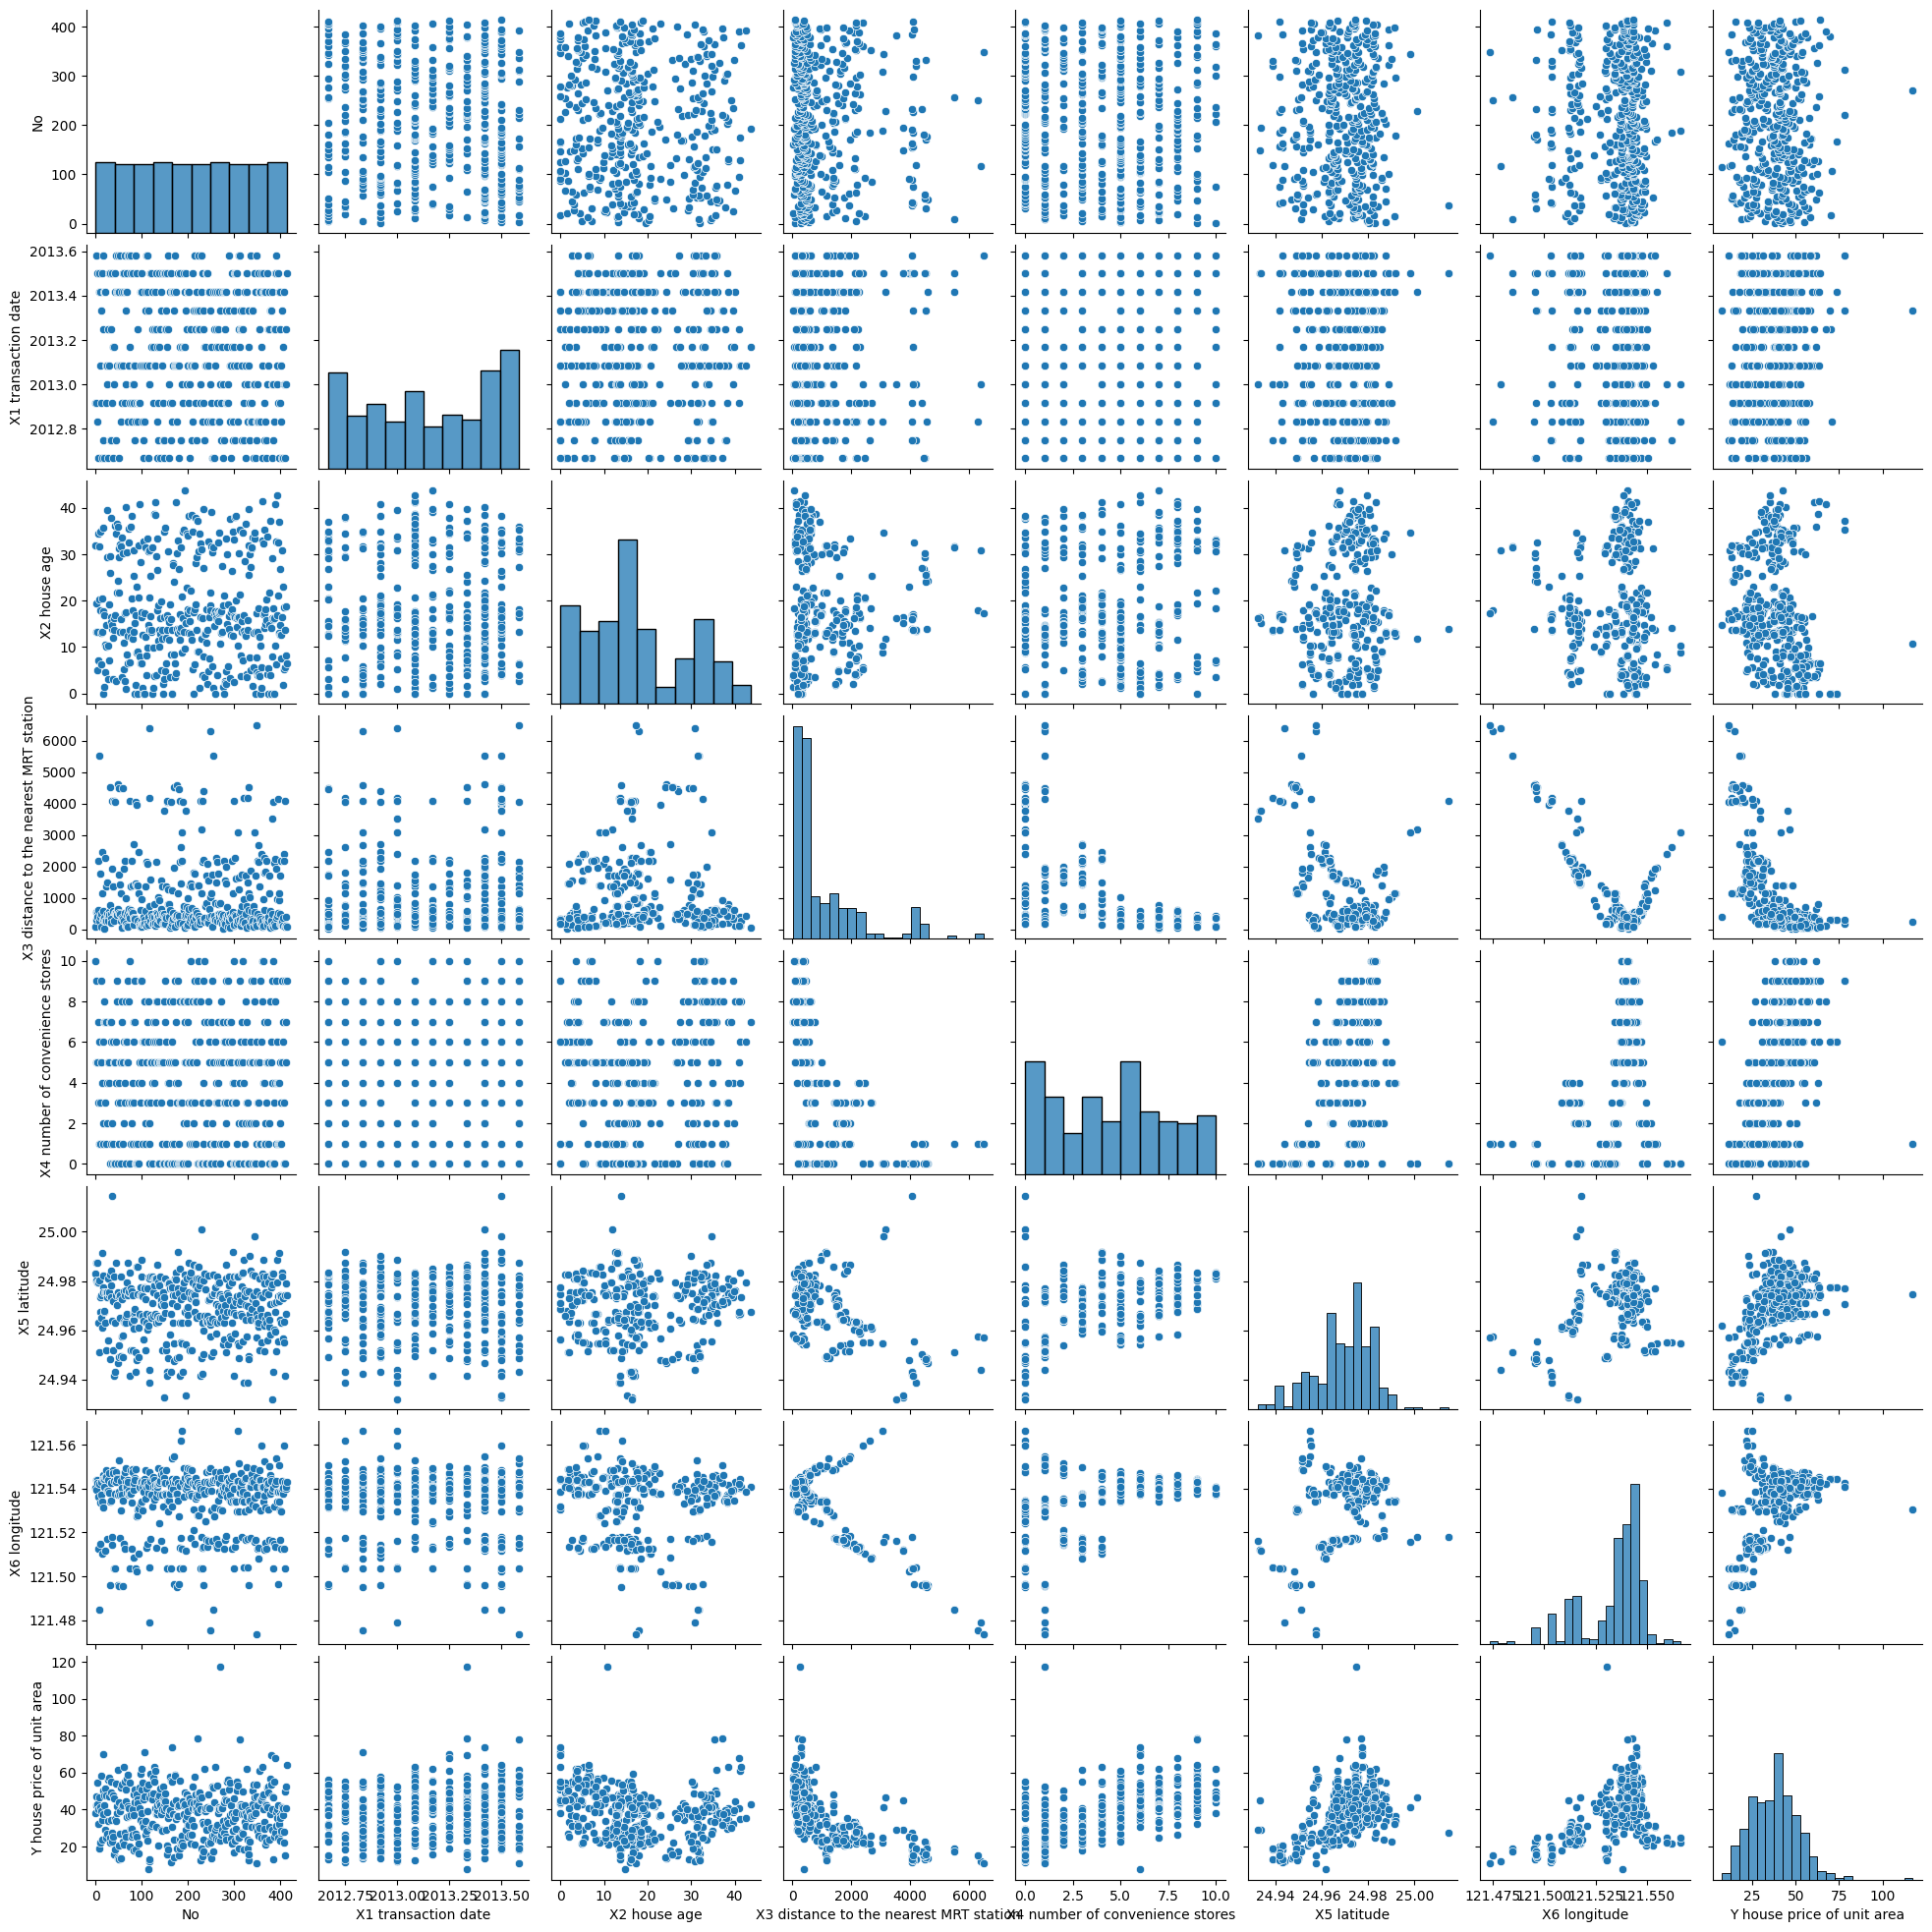

In [ ]:
sns.pairplot(rev)

Based off the pairplot it seems that we only really see a clear relationship with Y with X3, X5 and X6, with x5 & x6 both being normal distr. This means that I can condfidently ignore the other variables and looking at the other graphs it seems that their really isn't any clear interactions between the variables. So it seems like I can ignore most of my variables but just in case I am gonna run it with all of them the first time, and then re run it with only the three I identified. I am going to try to focus on mainly using X3, because of the three other variables, I find the distr. more intersting than the normal in X5 and X6. I am a little curious if MRT is indeed the best variable to infer the house price per area on




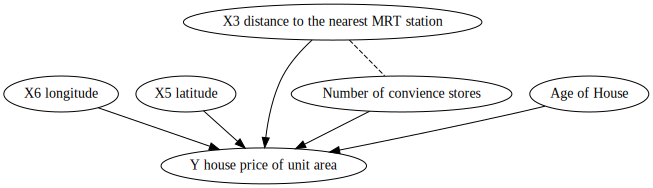

In [ ]:
rev = rev.rename({'X6 longitude':'Long','Y house price of unit area':'HouseP','X5 latitude':'Lat','X3 distance to the nearest MRT station':'Dist','X4 number of convenience stores':'Stores','X2 house age':'age'}, axis =1 )
!pip install graphviz
import graphviz as gr
#DAG
g = gr.Digraph()
g.node(name="HouseP", label="Y house price of unit area")
g.node(name="Long", label="X6 longitude")
g.node(name="Lat", label="X5 latitude")
g.node(name="Dist", label="X3 distance to the nearest MRT station")
g.node(name="Stores", label= "Number of convience stores")
g.node(name="age", label="Age of House")


g.edge(tail_name="Dist", head_name="HouseP")
g.edge(tail_name="Long", head_name="HouseP")
g.edge(tail_name="Lat", head_name="HouseP")
g.edge(tail_name="age", head_name="HouseP")
g.edge(tail_name="Stores", head_name="HouseP")

g.edge(tail_name="Dist", head_name="Stores", style="dashed", dir="none")


g

Just a rough DAG, I don't really know if there is any other linkages between the variables. And the one the only connection between variables is based off the fact that it makes convience stores to be placed in higher traffic areas, so MRT's and convience stores are going to be close together.

In [ ]:
features = ["Dist",	"Lat","Long","Stores", "age"]
#Just renaming them cuz I don't want to type out the names every time
X = rev[features]
Y = rev["HouseP"].to_numpy()

In [ ]:
with pm.Model() as model_rev:
    s = pm.HalfNormal('s')
    μ_ = pmb.BART("μ_", X,np.log(Y), m=50) #log around Y
    μ = pm.Deterministic("μ",pm.math.exp(μ_)) #exp it all once BART is done
    y = pm.Gamma("y", mu=μ, sigma=s,  observed=Y) #The distr for distance looked similar enough to a gamma, so for my first try, I am just gonna run it with this
    idata_revs = pm.sample(compute_convergence_checks=False)


Output()

Output()

<Axes: xlabel='y'>

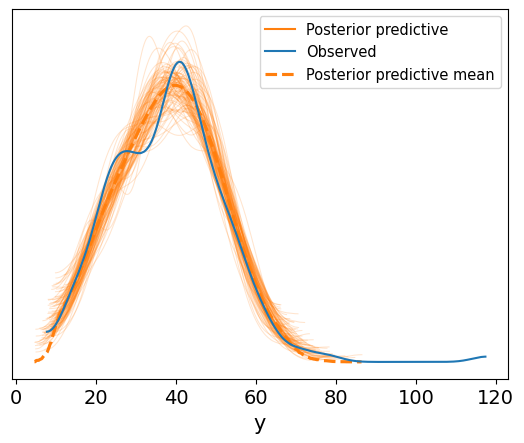

In [ ]:
pm.sample_posterior_predictive(idata_revs,model_rev, extend_inferencedata=True)
az.plot_ppc(idata_revs, num_pp_samples=100, colors=["C1", "C0", "C1"],)

That double bump is making me think that their is some interaction that I am missing from my model. I might try to see if there is anything I could do to try and fix it.

In [ ]:
posterior_mean = idata_revs.posterior["μ"]

μ_hdi = az.hdi(ary=idata_revs, group="posterior", var_names=["μ"], hdi_prob=0.74)
pps = az.extract(
    idata_revs, group="posterior_predictive", var_names=["y"]
).T

In [ ]:
Xn = X.to_numpy()

In [ ]:
X

,Dist,Lat,Long,Stores,age
0,84.87882,24.98298,121.54024,10,32.0
1,306.59470,24.98034,121.53951,9,19.5
2,561.98450,24.98746,121.54391,5,13.3
3,561.98450,24.98746,121.54391,5,13.3
4,390.56840,24.97937,121.54245,5,5.0
...,...,...,...,...,...
409,4082.01500,24.94155,121.50381,0,13.7
410,90.45606,24.97433,121.54310,9,5.6
411,390.96960,24.97923,121.53986,7,18.8
412,104.81010,24.96674,121.54067,5,8.1


In [ ]:
Xn

array([[ 84.87882,  24.98298, 121.54024,  10.     ,  32.     ],
       [306.5947 ,  24.98034, 121.53951,   9.     ,  19.5    ],
       [561.9845 ,  24.98746, 121.54391,   5.     ,  13.3    ],
       ...,
       [390.9696 ,  24.97923, 121.53986,   7.     ,  18.8    ],
       [104.8101 ,  24.96674, 121.54067,   5.     ,   8.1    ],
       [ 90.45606,  24.97433, 121.5431 ,   9.     ,   6.5    ]])

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


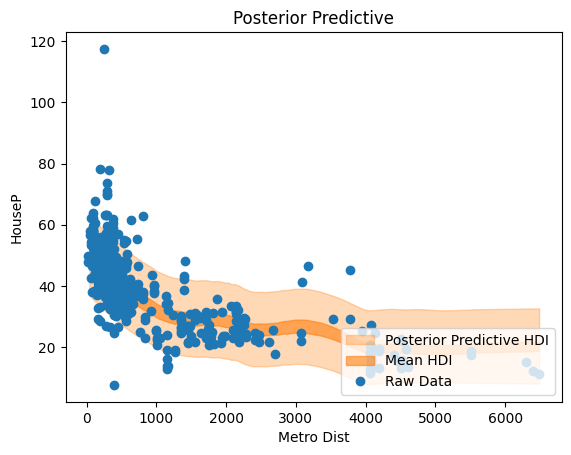

In [ ]:
idx = np.argsort(Xn[:, 0])
fig, ax = plt.subplots()

az.plot_hdi(
    x=Xn[:, 0],
    y=pps,
    ax=ax,
    hdi_prob=0.93,
    fill_kwargs={"alpha": 0.3, "label": r"Posterior Predictive HDI"},
)

az.plot_hdi(
    x=Xn[:, 0],
    y=posterior_mean,
    ax=ax,
    hdi_prob=0.74,
    fill_kwargs={"alpha": 0.6, "label": r"Mean HDI"},
)
ax.plot(rev["Dist"], rev["HouseP"], "o", c="C0", label="Raw Data")
ax.legend(loc="lower right")
ax.set(
    title="Posterior Predictive",
    xlabel="Metro Dist",
    ylabel="HouseP",
);


So it captures the majority of my data, but we still do have a good portion of my data just not included. Also majority of my data is very front heavy so its hard to be ensure accuracy, as we move to the right. Also I am missing some of the extremes near the start, maybe some of my predictors are weighing down my predicted variables because I do feel like I have a lot more than needed since I just threw in a bunch.

array([<Axes: xlabel='Dist'>, <Axes: xlabel='Lat'>, <Axes: xlabel='Long'>,
       <Axes: xlabel='Stores'>, <Axes: xlabel='age'>], dtype=object)

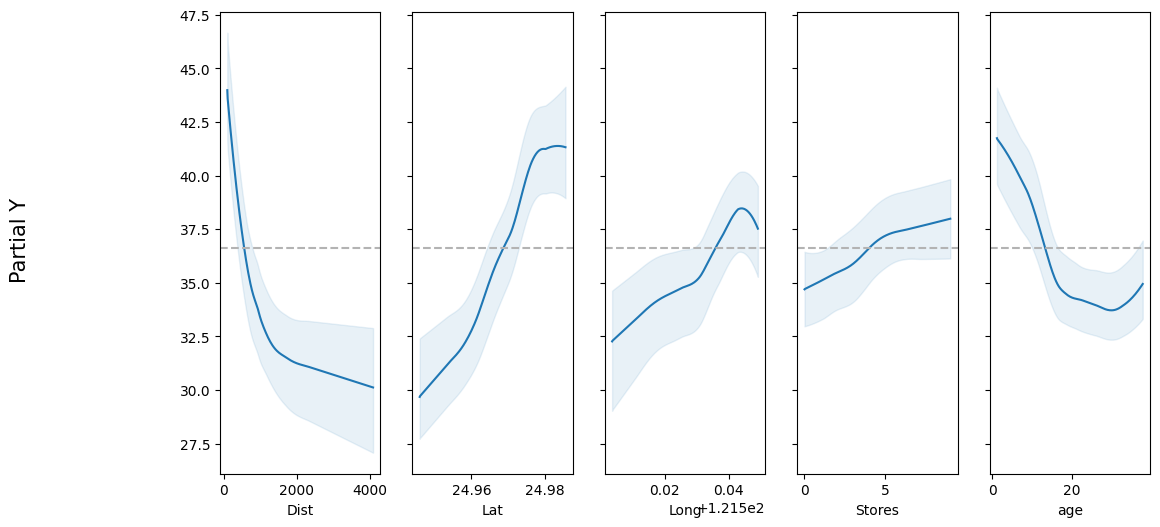

In [ ]:
pmb.plot_pdp(μ_, X, Y, grid=(1, 5), func=np.exp, figsize = (12,6))


So its looks like if we held the other variables at a constant, the further we get from a metro station, the more expensive our houses get, latitude has the opposite relationship, but not as steep. Stores is very positively linear and age is like a less extreme version of distance, with the exception that it curves up near the the end.

It seems as Dist and age share similar enough trends with the exception of their ends, but everything eles has this very obviosly positive trend.

array([<Axes: xlabel='Dist'>, <Axes: xlabel='Lat'>, <Axes: xlabel='Long'>,
       <Axes: xlabel='Stores'>, <Axes: xlabel='age'>], dtype=object)

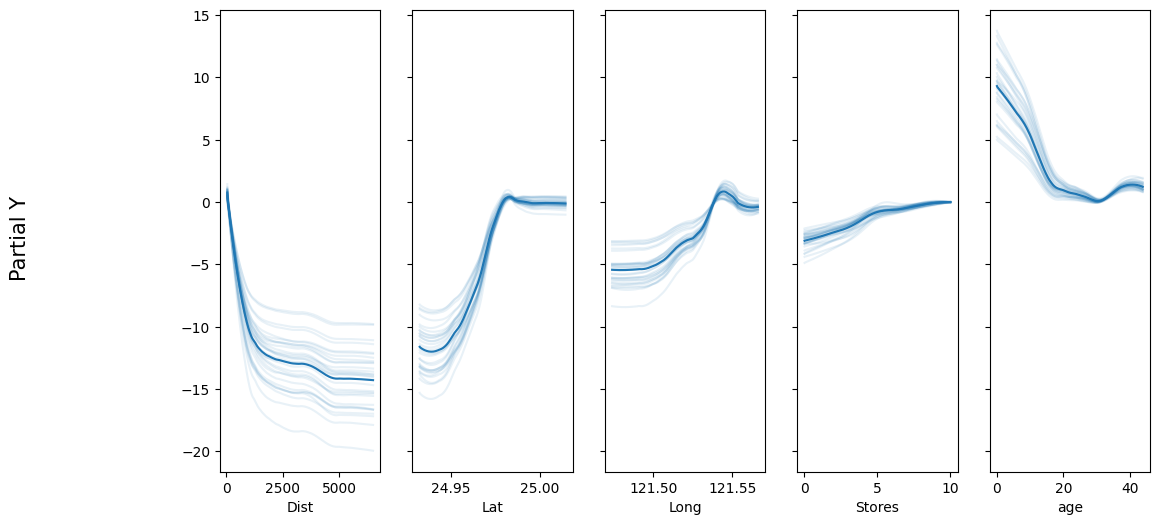

In [ ]:
pmb.plot_ice( μ_, X, Y, grid=(1, 5), func=np.exp, figsize = (12,6))

Now lets look for paralleness! With the expcetion for Distance,they all tend to vary whenever we get really right which is interesting. Also it seems that dist and age varies the most between all the other variables and everything else is vary consistent in comparason.

<Axes: ylabel='R²'>

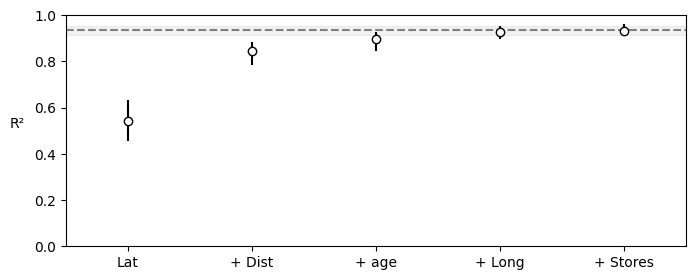

In [ ]:
vi_rev= pmb.compute_variable_importance(idata_revs, μ_, X)
pmb.plot_variable_importance(vi_rev)

So it looks like the biggest predicitors for us would be Stores, longitude, and age, so I am gonna re run our model but with only these var. I am honestly more surprised at how bad an indicator latitude is but how good an indicate longitude is, as both share a similar norm distr, so i expected them to perform similarly.

After doing looking at google maps this proves even more confusing, as just north of the Xindiax district (the area the data surveyed) is Taipei, but to the east and west of the Xindian distr. are mainly forested areas. So accordingly, the further north / more your latitude increase so should the house price/area, and east & west should have the opposite effect as you venture more and more into the forested areas, house cost per area should down. I might be missing something from this for example my model might have been built wrong, as it feels like the opposite should happen, but it just isn't so I dont know. I might come backt to this later, for right now lets just foces on simplifying our model and figuring out that bump from earlier.

Also looking back out our pairplot, Age is kind of weird and doesn'y really have a clear relationship with the house price, its similarish to a parabola but its really just missing alot of data inbetween its two extremes to really say anything.

In [ ]:
features = ["Stores","Long","age"]
X = rev[features]
Y = rev["HouseP"].to_numpy()

In [ ]:
with pm.Model() as model_rev2:
    s = pm.HalfNormal('s',1000)
    μ = pmb.BART("μ", X,Y, m=50)
    y = pm.Normal("y", mu=μ, sigma=s,  observed=Y) #likelihood. No point in it still being a gamma cuz i removed dist, so im defaulting to normal
    idata_revs2 = pm.sample(compute_convergence_checks=False)


Output()

Output()

<Axes: xlabel='y'>

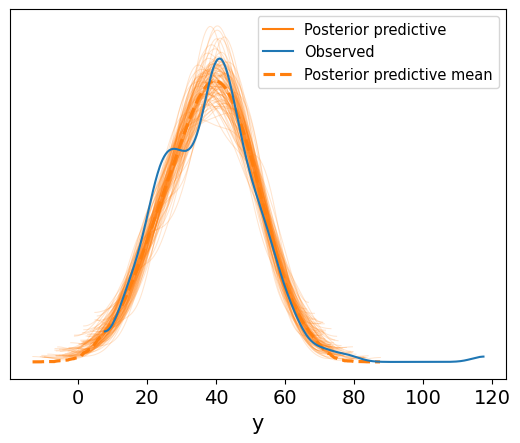

In [ ]:
pm.sample_posterior_predictive(idata_revs2,model_rev2, extend_inferencedata=True)
az.plot_ppc(idata_revs2, num_pp_samples=100, colors=["C1", "C0", "C1"],)

 Looking back it actually seems that we aren't doing that much better or worse, so it seems that other variables really weren't doing much of anything. Also it seems that we are missing alot of data near the end.

In [ ]:
posterior_mean = idata_revs2.posterior["μ"]

μ_hdi = az.hdi(ary=idata_revs2, group="posterior", var_names=["μ"], hdi_prob=0.74)
pps = az.extract(
    idata_revs2, group="posterior_predictive", var_names=["y"]
).T

In [ ]:
Xn = X.to_numpy()
Xn

array([[ 10.     , 121.54024,  32.     ],
       [  9.     , 121.53951,  19.5    ],
       [  5.     , 121.54391,  13.3    ],
       ...,
       [  7.     , 121.53986,  18.8    ],
       [  5.     , 121.54067,   8.1    ],
       [  9.     , 121.5431 ,   6.5    ]])

In [ ]:
X

,Stores,Long,age
0,10,121.54024,32.0
1,9,121.53951,19.5
2,5,121.54391,13.3
3,5,121.54391,13.3
4,5,121.54245,5.0
...,...,...,...
409,0,121.50381,13.7
410,9,121.54310,5.6
411,7,121.53986,18.8
412,5,121.54067,8.1


/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


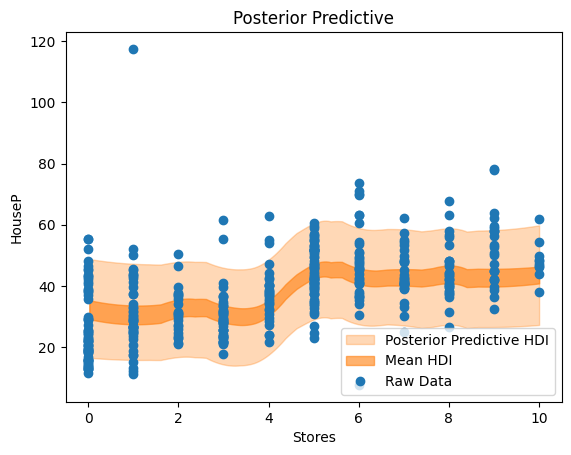

In [ ]:
idx = np.argsort(Xn[:, 0])
fig, ax = plt.subplots()

az.plot_hdi(
    x=Xn[:, 0],
    y=pps,
    ax=ax,
    hdi_prob=0.93,
    fill_kwargs={"alpha": 0.3, "label": r"Posterior Predictive HDI"},
)

az.plot_hdi(
    x=Xn[:, 0],
    y=posterior_mean,
    ax=ax,
    hdi_prob=0.74,
    fill_kwargs={"alpha": 0.6, "label": r"Mean HDI"},
)
ax.plot(rev["Stores"], rev["HouseP"], "o", c="C0", label="Raw Data")
ax.legend(loc="lower right")
ax.set(
    title="Posterior Predictive",
    xlabel="Stores",
    ylabel="HouseP",
);

This is alot better now. We still have some missing data points near the middle but for the most part its pretty accurate. Alot of our data points are also ontop of each other so it looks a lot more inaccurate because of that.

We also still see that big bump between 2 and 4 in the raw data, and I still need to figure out how to account for that. Majority of our not accounted for data is actually near the start of our model so I think i am missing something. I'm gonna go back to the drawing board in order to figure this out but the model I have currently isn't horrible either it does miss alot of the extremes but I shouldn't try to force them to fit fearing overfitting.

array([<Axes: xlabel='Stores'>, <Axes: xlabel='Long'>,
       <Axes: xlabel='age'>], dtype=object)

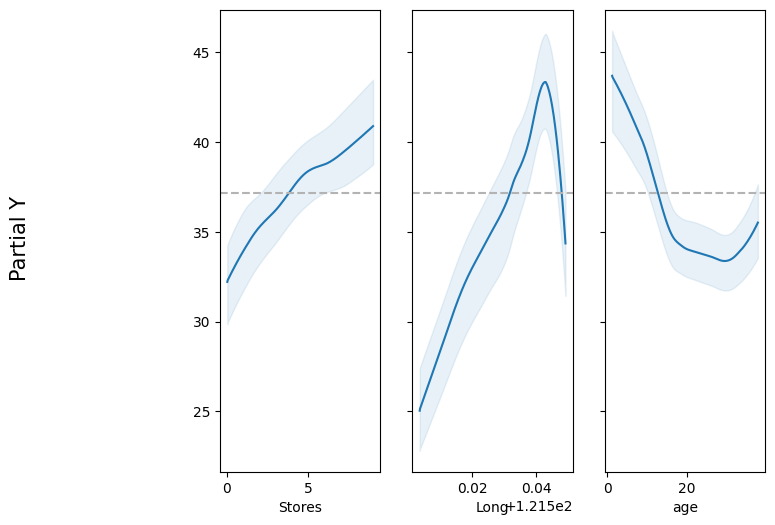

In [ ]:
pmb.plot_pdp(μ_, X, Y, grid=(1, 5), func=np.exp, figsize = (12,6))

Im unsure why Long just falls off near the end, maybe its cuz of hte large forested areas that causes longitude to just fall off cuz of the lack of high costed houses. but stores is fairly consistent throughout so atleast thats good.
Nothing to interesting in age, execept for the steep drop off

array([<Axes: xlabel='Stores'>, <Axes: xlabel='Long'>,
       <Axes: xlabel='age'>], dtype=object)

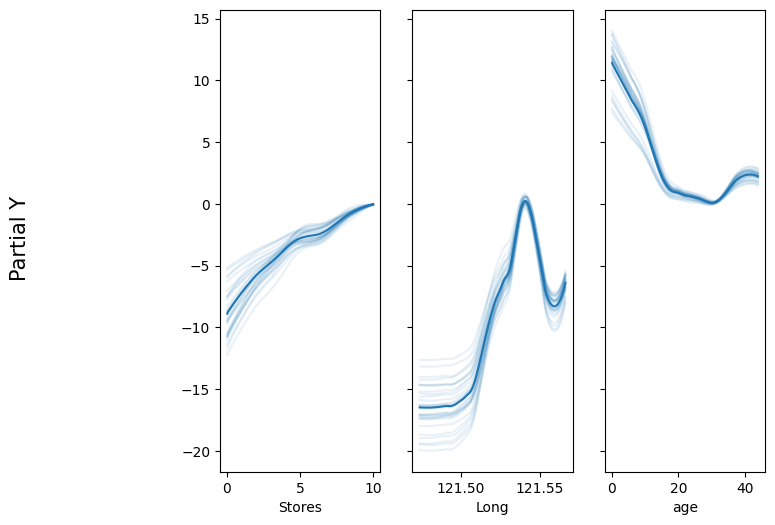

In [ ]:
pmb.plot_ice( μ_, X, Y, grid=(1, 5), func=np.exp, figsize = (12,6))

Some things that are particularly interesting here is the large difference in slope with Stores from 5-10 and the large amount of variation in general present in comparison to the other model.

<Axes: ylabel='R²'>

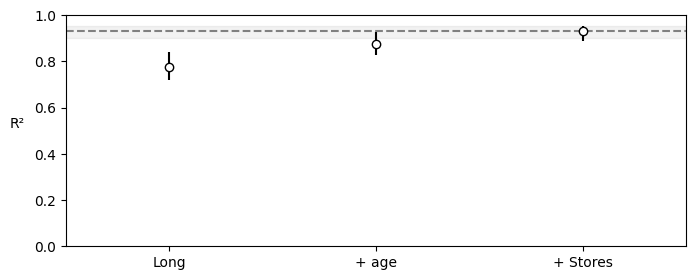

In [ ]:
vi_rev2= pmb.compute_variable_importance(idata_revs2, μ, X)
pmb.plot_variable_importance(vi_rev2)

It looks like can just remove Longitude and just let the  number of stores and hte age of the house in my model. Luckily, I still hit that 2+ predictor requirement with this. I might remove Longitude, but currently I want to focus more on meeting that bump. I think we

In [ ]:
features = ["Stores","age"]
X = rev[features]
Y = rev["HouseP"].to_numpy()

In [ ]:
with pm.Model() as model_rev3:
    s = pm.HalfNormal('s',1000)
    μ = pmb.BART("μ", X,Y, m=50)
    y = pm.Normal("y", mu=μ, sigma=s,  observed=Y) #likelihood. No point in it still being a gamma cuz i removed dist, so im defaulting to normal
    idata_revs3 = pm.sample(compute_convergence_checks=False)


Output()

Output()

<Axes: xlabel='y'>

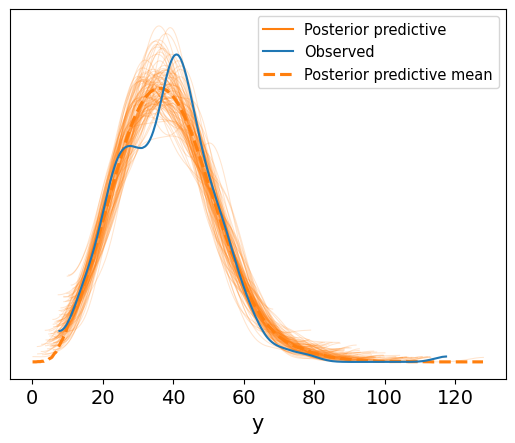

In [ ]:
pm.sample_posterior_predictive(idata_revs3,model_rev3, extend_inferencedata=True)
az.plot_ppc(idata_revs3, num_pp_samples=100, colors=["C1", "C0", "C1"],)

One note that it does end before zero and does not go negative something my other models don't have. Other than that it preforms similarly enough where it isn't to intrestin . It isnt as tall as the others though, but does i believe model our end behaviors a lot better. I asked mr.A and he said if I don't have something to predicts those bumps then I just won't be able to model them. I'll try to see if I can get that down on friday, but right now I just want to get this model down and analyzed

In [ ]:
X1n= X.to_numpy()

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


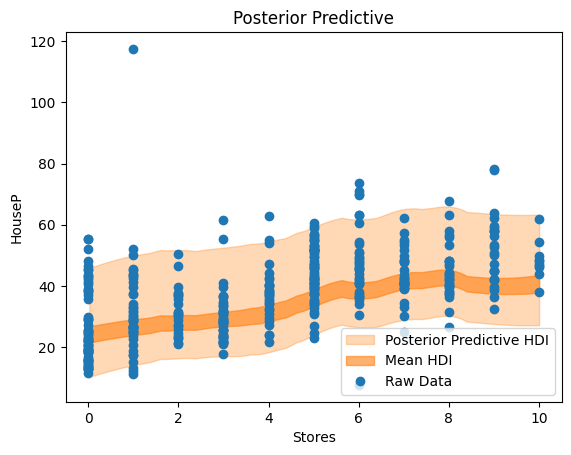

In [ ]:
posterior_mean = idata_revs3.posterior["μ"]

μ_hdi = az.hdi(ary=idata_revs3, group="posterior", var_names=["μ"], hdi_prob=0.74)
pps = az.extract(
    idata_revs3, group="posterior_predictive", var_names=["y"]
).T

idx = np.argsort(X1n[ :, 0])
fig, ax = plt.subplots()

az.plot_hdi(
    x=X1n[:, 0],
    y=pps,
    ax=ax,
    hdi_prob=0.93,
    fill_kwargs={"alpha": 0.3, "label": r"Posterior Predictive HDI"},
)

az.plot_hdi(
    x=X1n[:, 0],
    y=posterior_mean,
    ax=ax,
    hdi_prob=0.74,
    fill_kwargs={"alpha": 0.6, "label": r"Mean HDI"},
)
ax.plot(rev["Stores"], rev["HouseP"], "o", c="C0", label="Raw Data")
ax.legend(loc="lower right")
ax.set(
    title="Posterior Predictive",
    xlabel="Stores",
    ylabel="HouseP",
);

I am prett sure this one is way better than our previous one. We are hitting alot of out Raw data and yes we still are missing some of oure extreme, but its just overall signficantly better than our previous one.

array([<Axes: xlabel='Stores'>, <Axes: xlabel='age'>], dtype=object)

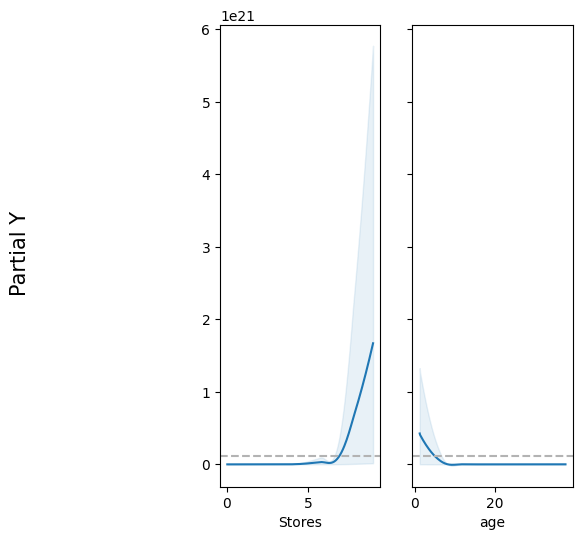

In [ ]:
pmb.plot_pdp(μ, X, Y, grid=(1, 5), func=np.exp, figsize = (12,6))

Huh. This is so strange. I am really curious why our data turned out like this. It lost like any sort of variation at the end. I am so confused on why my graphs look like this. After asking Mr.A he mentioned that I probably have a couple of outliers causing this problem, so thats the goal for tomorrow. It probably is that one large point on x=2

array([<Axes: xlabel='Stores'>, <Axes: xlabel='age'>], dtype=object)

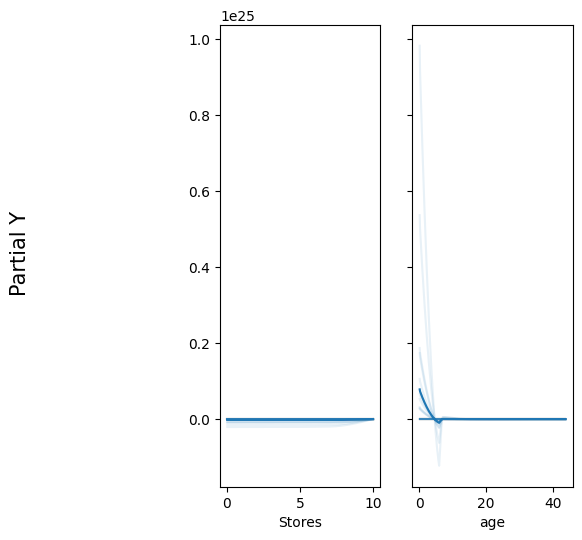

In [ ]:
pmb.plot_ice( μ, X, Y, grid=(1, 5), func=np.exp, figsize = (12,6))

This just isnt reliable because of the existance of outliers. I think my next model is just gonna focus primarily on removing those outliers and then rerunning my code.

In [ ]:
vi_rev3= pmb.compute_variable_importance(idata_revs3, μ_, X)
pmb.plot_variable_importance(vi_rev3)

In [ ]:
rev.to_numpy()
rev.HouseP
A =sorted(rev.HouseP, reverse = True)
A #From this we can clearly see the problem. 117.5 is our outlier and no I can just remove it by adding that a query to ignore all data points with HouseP > 100

[117.5,
 78.3,
 78.0,
 73.6,
 71.0,
 70.1,
 69.7,
 67.7,
 63.9,
 63.3,
 63.3,
 63.2,
 62.9,
 62.2,
 62.1,
 61.9,
 61.5,
 60.7,
 60.7,
 59.6,
 59.5,
 59.0,
 58.8,
 58.1,
 58.1,
 58.0,
 57.8,
 57.4,
 57.1,
 56.8,
 56.8,
 56.3,
 56.2,
 55.9,
 55.5,
 55.3,
 55.3,
 55.2,
 55.1,
 55.0,
 55.0,
 55.0,
 54.8,
 54.4,
 54.4,
 54.4,
 53.9,
 53.7,
 53.5,
 53.5,
 53.3,
 53.3,
 53.0,
 53.0,
 52.7,
 52.5,
 52.2,
 52.2,
 52.2,
 51.8,
 51.8,
 51.7,
 51.7,
 51.6,
 51.6,
 51.4,
 51.0,
 51.0,
 50.8,
 50.7,
 50.5,
 50.4,
 50.2,
 50.0,
 49.8,
 49.7,
 49.5,
 49.3,
 49.3,
 49.0,
 48.6,
 48.5,
 48.5,
 48.2,
 48.2,
 48.1,
 48.1,
 48.0,
 48.0,
 48.0,
 47.9,
 47.7,
 47.7,
 47.4,
 47.3,
 47.3,
 47.1,
 47.1,
 47.0,
 47.0,
 46.8,
 46.7,
 46.6,
 46.6,
 46.6,
 46.4,
 46.2,
 46.1,
 46.1,
 46.0,
 45.9,
 45.7,
 45.5,
 45.5,
 45.4,
 45.4,
 45.3,
 45.2,
 45.1,
 45.1,
 44.9,
 44.8,
 44.7,
 44.5,
 44.3,
 44.3,
 44.2,
 44.0,
 44.0,
 43.9,
 43.8,
 43.7,
 43.5,
 43.5,
 43.4,
 43.2,
 43.2,
 43.1,
 43.1,
 42.9,
 42.8,
 42.7,
 42.6

In [ ]:
rev= pd.read_csv('https://raw.githubusercontent.com/YoishD/Data-Science-B7/refs/heads/main/Real%20estate%20valuation%20data%20set.csv')
rev = rev.rename({'X6 longitude':'Long','Y house price of unit area':'HouseP','X5 latitude':'Lat','X3 distance to the nearest MRT station':'Dist','X4 number of convenience stores':'Stores','X2 house age':'age','X1 transaction date':'date'}, axis =1 )
rev.loc[rev['HouseP'] == 117.5]
rev_data = rev[((rev.No != 271) &( rev.date != 2013.333) & (rev.age != 10.8) &(rev.Dist != 252.5822) &(rev.Stores != 1) &(rev.Lat != 24.9746) &(rev.Long != 121.53046) &(rev.HouseP != 117.5))]

This code should have removed our problem child from our data so our code should be much more accurate now

In [ ]:
features = ["Dist",	"Lat","Long","Stores", "age"]
#Just renaming them cuz I don't want to type out the names every time
X = rev_data[features]
Y = rev_data["HouseP"].to_numpy()

In [ ]:
with pm.Model() as model_rev4:
    s = pm.HalfNormal('s')
    μ_ = pmb.BART("μ_", X,np.log(Y), m=50) #log around Y
    μ = pm.Deterministic("μ",pm.math.exp(μ_)) #exp it all once BART is done
    y = pm.Gamma("y", mu=μ, sigma=s,  observed=Y) #The distr for distance looked similar enough to a gamma, so for my first try, I am just gonna run it with this
    idata_revs4 = pm.sample(compute_convergence_checks=False)
#Redoing with OG model in order to see if any of the variable were effected by our outlier

Output()

Output()

<Axes: xlabel='y'>

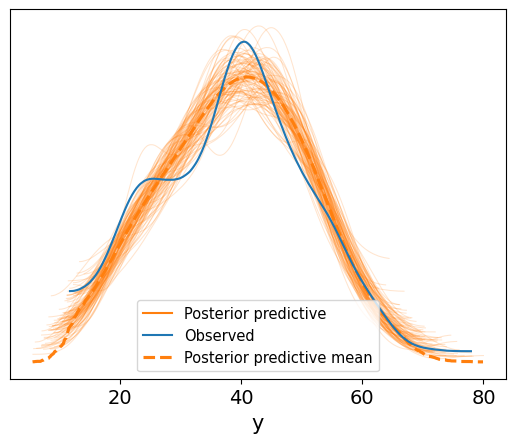

In [ ]:
pm.sample_posterior_predictive(idata_revs4,model_rev4, extend_inferencedata=True)
az.plot_ppc(idata_revs4, num_pp_samples=100, colors=["C1", "C0", "C1"],)

In [ ]:
X1n= X.to_numpy()

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


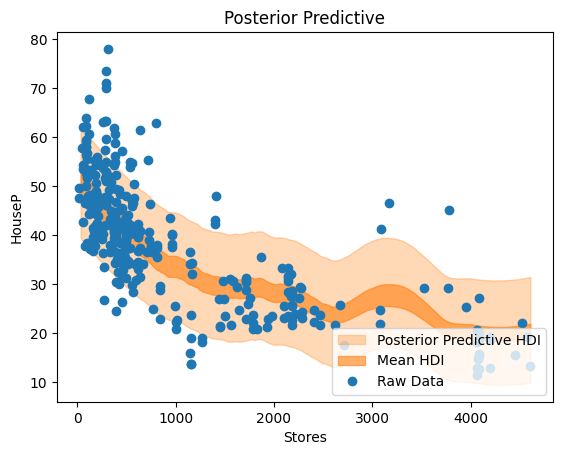

In [ ]:
posterior_mean = idata_revs4.posterior["μ"]

μ_hdi = az.hdi(ary=idata_revs4, group="posterior", var_names=["μ"], hdi_prob=0.74)
pps = az.extract(
    idata_revs4, group="posterior_predictive", var_names=["y"]
).T

idx = np.argsort(X1n[ :, 0])
fig, ax = plt.subplots()

az.plot_hdi(
    x=X1n[:, 0],
    y=pps,
    ax=ax,
    hdi_prob=0.93,
    fill_kwargs={"alpha": 0.3, "label": r"Posterior Predictive HDI"},
)

az.plot_hdi(
    x=X1n[:, 0],
    y=posterior_mean,
    ax=ax,
    hdi_prob=0.74,
    fill_kwargs={"alpha": 0.6, "label": r"Mean HDI"},
)
ax.plot(rev_data["Dist"], rev_data["HouseP"], "o", c="C0", label="Raw Data")
ax.legend(loc="lower right")
ax.set(
    title="Posterior Predictive",
    xlabel="Stores",
    ylabel="HouseP",
);

array([<Axes: xlabel='Dist'>, <Axes: xlabel='Lat'>, <Axes: xlabel='Long'>,
       <Axes: xlabel='Stores'>, <Axes: xlabel='age'>], dtype=object)

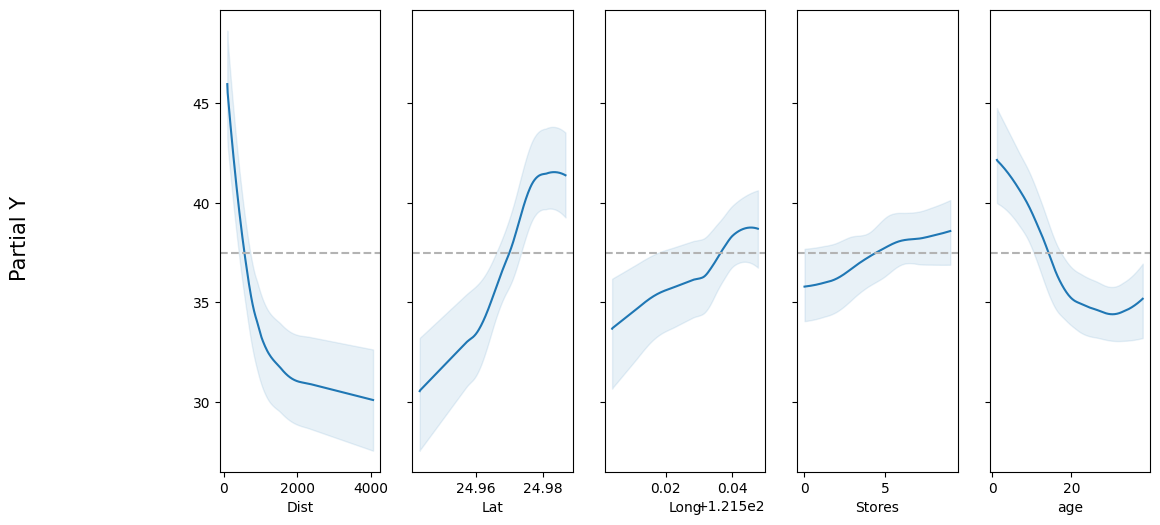

In [ ]:
pmb.plot_pdp(μ_, X, Y, grid=(1, 5), func=np.exp, figsize = (12,6))

array([<Axes: xlabel='Dist'>, <Axes: xlabel='Lat'>, <Axes: xlabel='Long'>,
       <Axes: xlabel='Stores'>, <Axes: xlabel='age'>], dtype=object)

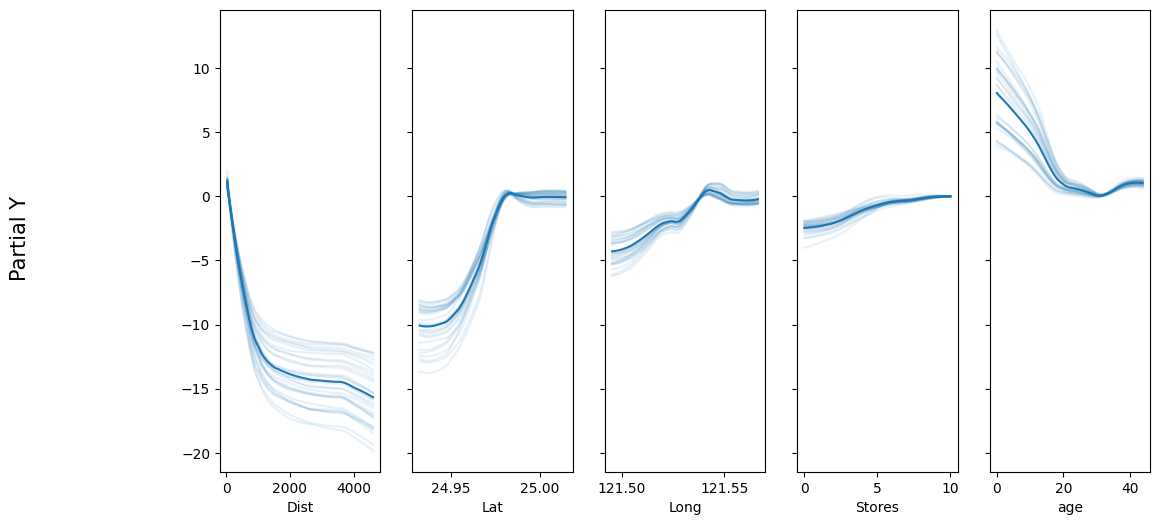

In [ ]:
pmb.plot_ice( μ_, X, Y, grid=(1, 5), func=np.exp, figsize = (12,6))

<Axes: ylabel='R²'>

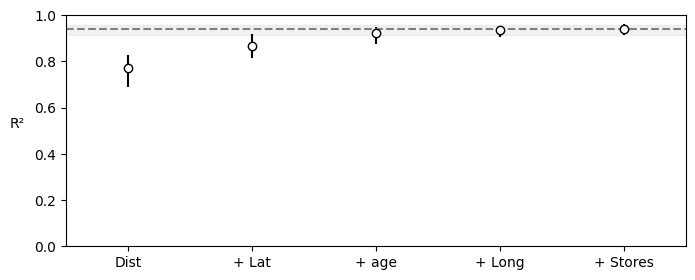

In [ ]:
vi_rev4= pmb.compute_variable_importance(idata_revs4, μ_, X)
pmb.plot_variable_importance(vi_rev4)

In [ ]:
features = ["Long","Stores", "age"]
#Just renaming them cuz I don't want to type out the names every time
X = rev_data[features]
Y = rev_data["HouseP"].to_numpy()

In [ ]:
with pm.Model() as model_rev5:
    s = pm.HalfNormal('s',1000)
    μ = pmb.BART("μ", X,Y, m=50)
    y = pm.Normal("y", mu=μ, sigma=s,  observed=Y) #likelihood. No point in it still being a gamma cuz i removed dist, so im defaulting to normal
    idata_revs5 = pm.sample(compute_convergence_checks=False)

Output()

Output()

<Axes: xlabel='y'>

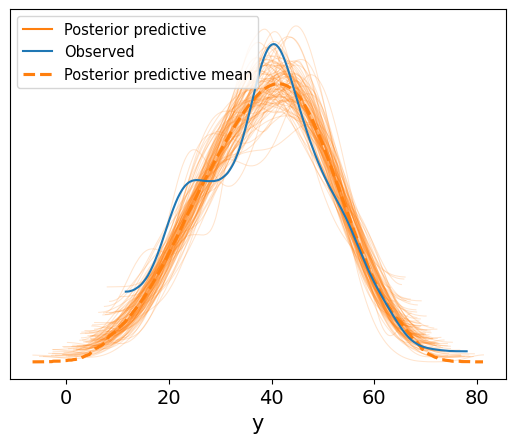

In [ ]:
pm.sample_posterior_predictive(idata_revs5,model_rev5, extend_inferencedata=True)
az.plot_ppc(idata_revs5, num_pp_samples=100, colors=["C1", "C0", "C1"],)

nothing to interesting here. still same old same old

In [ ]:
X1n= X.to_numpy()

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


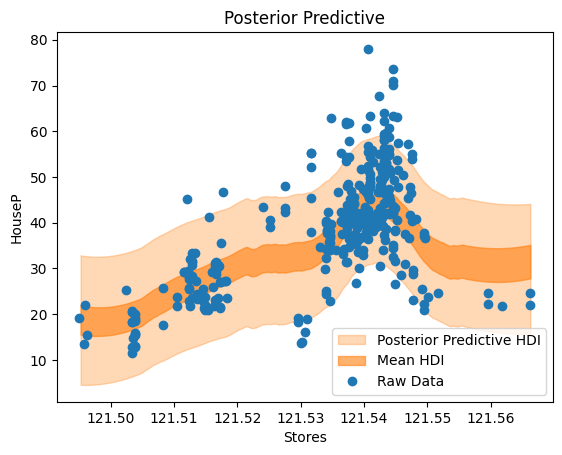

In [ ]:
posterior_mean = idata_revs5.posterior["μ"]

μ_hdi = az.hdi(ary=idata_revs5, group="posterior", var_names=["μ"], hdi_prob=0.74)
pps = az.extract(idata_revs5, group="posterior_predictive", var_names=["y"]).T

idx = np.argsort(X1n[ :, 0])
fig, ax = plt.subplots()

az.plot_hdi(
    x=X1n[:, 0],
    y=pps,
    ax=ax,
    hdi_prob=0.93,
    fill_kwargs={"alpha": 0.3, "label": r"Posterior Predictive HDI"},
)

az.plot_hdi(
    x=X1n[:, 0],
    y=posterior_mean,
    ax=ax,
    hdi_prob=0.74,
    fill_kwargs={"alpha": 0.6, "label": r"Mean HDI"},
)
ax.plot(rev_data["Long"], rev_data["HouseP"], "o", c="C0", label="Raw Data")
ax.legend(loc="lower right")
ax.set(
    title="Posterior Predictive",
    xlabel="Stores",
    ylabel="HouseP",
);

HDI is to restrictive to fully capture all of our data but we have the general trend. I am gonna try and figure out how to allow more deviations with our model

array([<Axes: xlabel='Long'>, <Axes: xlabel='Stores'>,
       <Axes: xlabel='age'>], dtype=object)

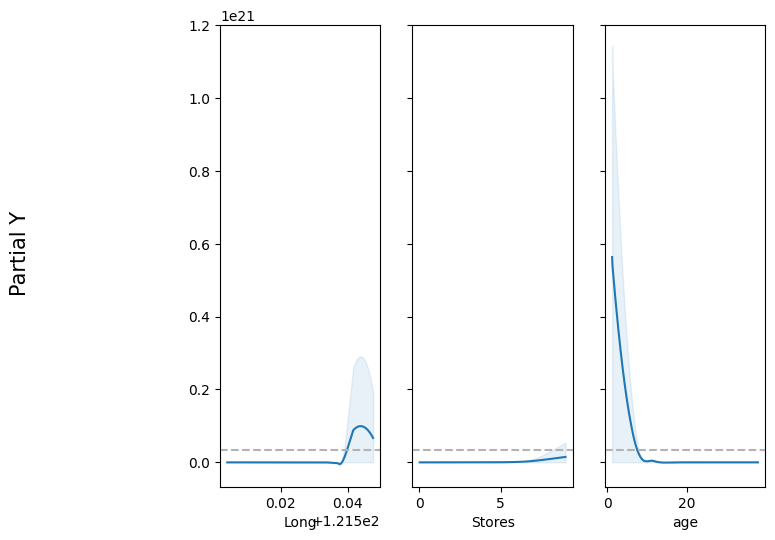

In [ ]:
pmb.plot_pdp(μ, X, Y, grid=(1, 5), func=np.exp, figsize = (12,6))

It shows that age has the most substantial influence on house price with a strong negative relationship as age increases. long has a minor effect all the way up until the end with a small increase, and stores has almost no effect. This is very different from our previous model where stores was the dominate effector.

array([<Axes: xlabel='Long'>, <Axes: xlabel='Stores'>,
       <Axes: xlabel='age'>], dtype=object)

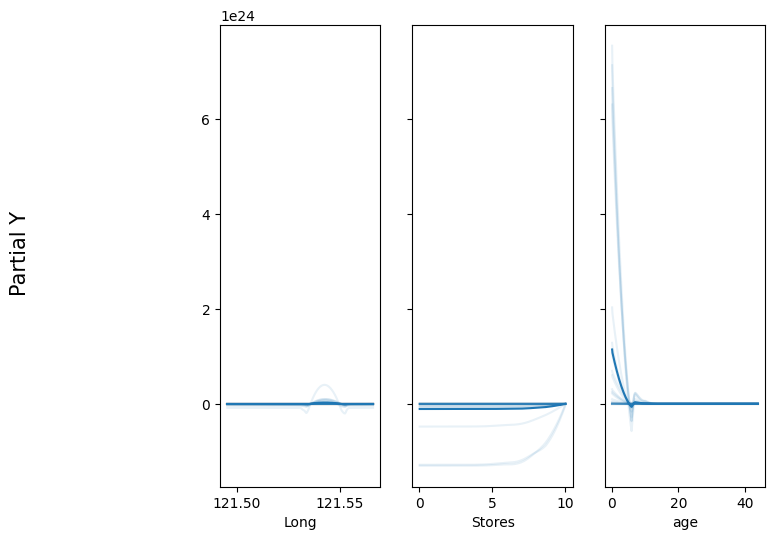

In [ ]:
pmb.plot_ice( μ, X, Y, grid=(1, 5), func=np.exp, figsize = (12,6))

Nothing to differnet from the PDP however, we do see some slight positive coorelation from stores but nothing to strong and we do see some positive from age with that light blue line dipping down

<Axes: ylabel='R²'>

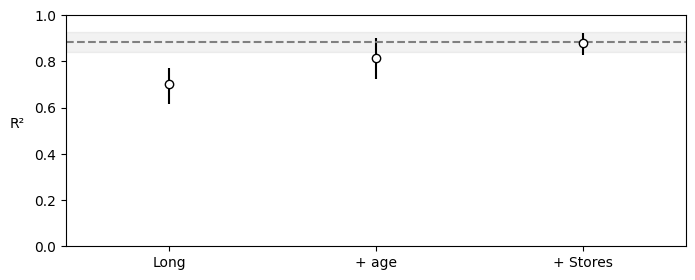

In [ ]:
vi_rev5= pmb.compute_variable_importance(idata_revs5, μ, X)
pmb.plot_variable_importance(vi_rev5)

I am going to drop Long and also switch up our model a bit to try to widen that HDI

In [ ]:
features = ["Stores", "age"]
#Just renaming them cuz I don't want to type out the names every time
X = rev_data[features]
Y = rev_data["HouseP"].to_numpy()

In [ ]:
with pm.Model() as model_rev6:
    μ = pmb.BART("μ", X_standardized, np.log(Y + 1), m=200)
    sigma = pm.HalfNormal("sigma", sigma=10)
    y = pm.LogNormal("y", mu=μ, sigma=sigma, observed=Y)
    idata_revs6 = pm.sample(draws=1000, tune=1000, compute_convergence_checks=False)

Output()

Output()

<Axes: xlabel='y'>

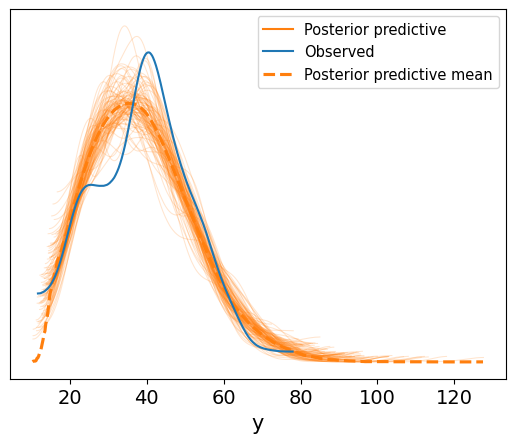

In [ ]:
pm.sample_posterior_predictive(idata_revs6,model_rev6, extend_inferencedata=True)
az.plot_ppc(idata_revs6, num_pp_samples=100, colors=["C1", "C0", "C1"],)

Not to bad. I mean nothing to interesting. I mean it works

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


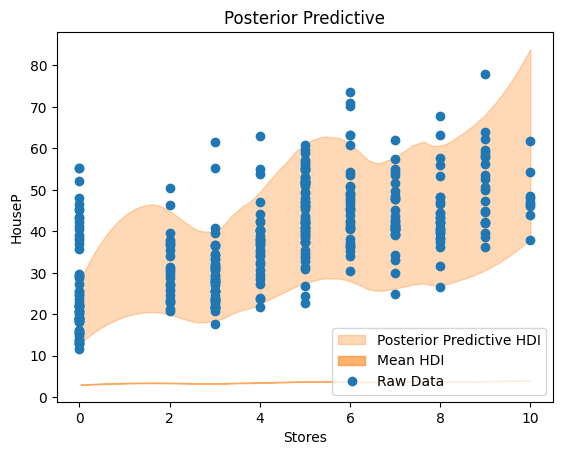

In [ ]:
X1n= X.to_numpy()
posterior_mean = idata_revs6.posterior["μ"]

μ_hdi = az.hdi(ary=idata_revs6, group="posterior", var_names=["μ"], hdi_prob=0.74)
pps = az.extract(idata_revs6, group="posterior_predictive", var_names=["y"]).T

idx = np.argsort(X1n[ :, 0])
fig, ax = plt.subplots()

az.plot_hdi(
    x=X1n[:, 0],
    y=pps,
    ax=ax,
    hdi_prob=0.93,
    fill_kwargs={"alpha": 0.3, "label": r"Posterior Predictive HDI"},
)

az.plot_hdi(
    x=X1n[:, 0],
    y=posterior_mean,
    ax=ax,
    hdi_prob=0.74,
    fill_kwargs={"alpha": 0.6, "label": r"Mean HDI"},
)
ax.plot(rev_data["Stores"], rev_data["HouseP"], "o", c="C0", label="Raw Data")
ax.legend(loc="lower right")
ax.set(
    title="Posterior Predictive",
    xlabel="Stores",
    ylabel="HouseP",
);

Honestly its fine. I keep on changing my models and variables, I don't feel like its getting better at all. This one also kind of wierd with that line at the bottom. I am acutally model the lower values of my data rlly well in this model just on the higher end Y values I am just not able to predict them.

array([<Axes: xlabel='Stores'>, <Axes: xlabel='age'>], dtype=object)

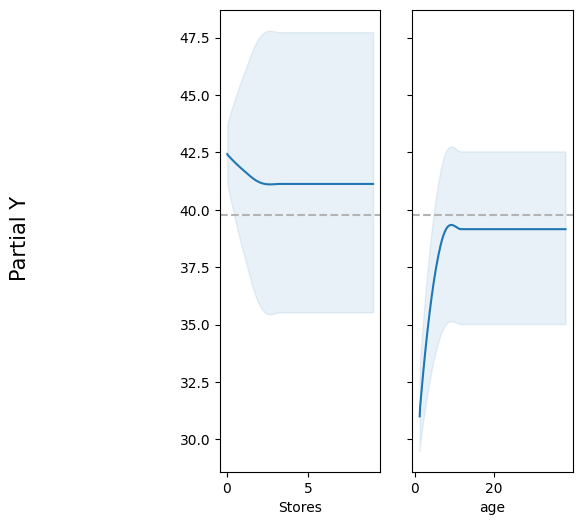

In [ ]:
pmb.plot_pdp(μ, X, Y, grid=(1, 5), func=np.exp, figsize = (12,6))

There is so much uncertaintiy. We have such big ranges esp for both variables , and the actual relationship has also changed from like super negative to super positive for age, and store actually has some noticible change fro the last pdp. I feel like our model doesn't need Stores and that we are some misinterpreting or overfitting our age variable.

array([<Axes: xlabel='Stores'>, <Axes: xlabel='age'>], dtype=object)

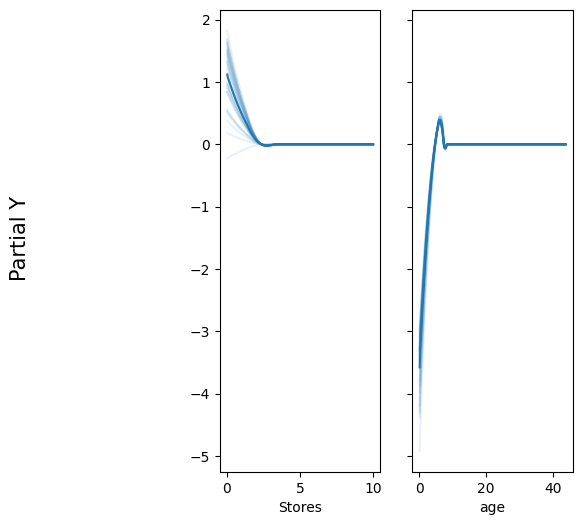

In [ ]:
pmb.plot_ice( μ, X, Y, grid=(1, 5), func=np.exp, figsize = (12,6))

Stores has a minimal effect, and the variability across observations is small. But now the relationship showcases in age has changed and lower costed homes less up until a point where it just goes linear.

<Axes: ylabel='R²'>

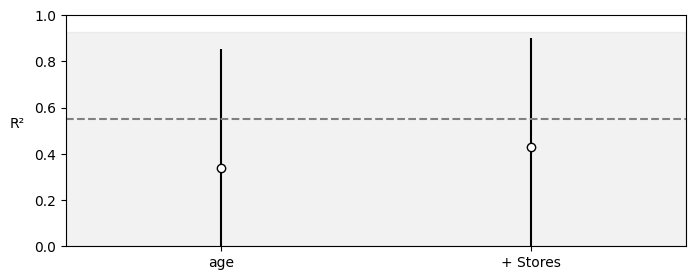

In [ ]:
vi_rev6= pmb.compute_variable_importance(idata_revs6, μ, X)
pmb.plot_variable_importance(vi_rev6)

Is this saying that both variables are as important, as it seems the gray scale covers the whole thing? I am defintly doing something wrong, I am just not sure what. Based of the ppc my models seems okay atleast just my pdps, ice plots and variable important are telling me that what I thnk is happnenig just isnt, and I just not sure why. It kinda sucks as by now I can't really ask Mr.A anymore questions so I think this where I kinda have to call it in. I probably should have done more research into the area this data was located in for more background information to actually see the variable interactions but it what it is.